# 부스팅 방법

In [2]:

from scipy.stats import norm
import numpy as np
import scipy as sp
from pandas.core import datetools 
import pandas as pd
import statsmodels.api as sm ## R 패키지에서 불러온것, 샘플데이터 옮겨쓸수 있는 프로젝트 있음. 회귀분석에 유용 
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk 
## 전처리 

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pylab 
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  """


committee 의모형을 사용하나 틀린부분만 좀더 보는 부스팅 방법
취합방법론과 목적이 다름 

취합방법론: 커미티가 다수결이나 랜덤 포레스트 처럼 성능이 좋은것들만 골라 최적화
부스트방법론: 커미티가 모형을 사용후 틀린부분만 찾아내어 다시 모형을 조정 

## 에이다 부스트

에이다 부스트와 같은 부스트(boost) 방법은 미리 정해진 모형 집합을 사용하는 것이 아니라 단계적으로 모형 집합에 포함할 개별 모형을 선택한다. 부스트 방법에서는 성능이 떨어지는 개별 모형을 weak classifier라고 한다.

또한 다수결 방법을 사용하지 않고 각 weak classifier들을 가중선형결합하여 최종 모형인 boosted classifier $C$를 생성한다. 



$$ C_{(m-1)}(x_i) = \alpha_1k_1(x_i) + \cdots + \alpha_{m-1}k_{m-1}(x_i) $$


$$ C_{m}(x_i) = C_{(m-1)}(x_i) + \alpha_m k_m(x_i) $$


다음은 SAMME(Stagewise Additive Modeling using a Multi-class Exponential loss function) 알고리즘을 사용한 에이다 부스트 방법이다. Scikit-Learn에서는 `AdaBoostClassifier` 클래스로 구현되어 있다.

* $k_m$ 선택 방법
 * 가중치 오차가 가장 적은 $k_m$
$$ E = \sum_{y_i \neq k_m(x_i)} w_i^{(m)} = \sum_{y_i \neq k_m(x_i)} e^{-y_i C_{m-1}(x_i)}$$ 

* $\alpha_m$ 결정 방법

$$ \epsilon_m = \dfrac{\sum_{y_i \neq k_m(x_i)} w_i^{(m)} }{ \sum_{i=1}^N w_i^{(m)}} $$

$$ \alpha_m = \frac{1}{2}\log\left( \frac{1 - \epsilon_m}{\epsilon_m}\right) $$ 


* 정규화(regularization)를 위해 learning rate $\nu < 1$를 추가

$$ C_{m}(x_i) = C_{(m-1)}(x_i) + \nu\alpha_m k_m(x_i) $$

i 번째 문제에 대하여 y에 포함 되지 않는다. - 커미티가 맞춘답에서는 고르지 않고 틀린답에 대해서는 y 에 들어감 
즉, 커미티가 맞추지 못한 것에 대해서만 따로 모아서 y로 만든후 다시 푼다 
만약 yi에 대해서 틀리게 되면 가중치를 준다 (벌점부여)
커미티가 xi에 대하여 예상한 값이 맞았으면(yi)라면 

Decision fuction이 맞았으면(정답을 맞추면) 1 
Decision fuction이 틀렸으면(정답이 아니면) -1
그래서 커미티 C(xi)가 맞는 값이 많으면 +가 되고 틀린 값이 많으면 -가 된다 

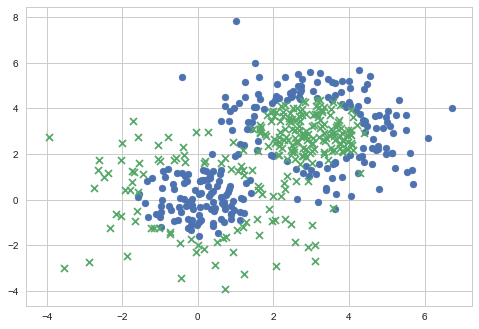

In [3]:
from sklearn.datasets import make_gaussian_quantiles

# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='o')
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='x')
plt.show()

In [4]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(X, y)

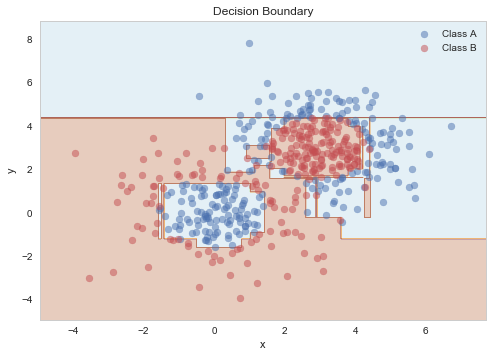

In [5]:
def plot_result(model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)

    for i, n, c in zip(range(2), "AB", "br"):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, alpha=0.5, label="Class %s" % n)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary')
    plt.grid(False)
    plt.show()
    
plot_result(tree)## 오버피팅된 영역들이 많이생김 

In [7]:
from sklearn.ensemble import AdaBoostClassifier
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, random_state=0), 
                               algorithm="SAMME", n_estimators=100) 
## decision tree 사용하여 여러번 틀린부분을 다시 보는 에이더 부스트를 사용
## max_depth가 2 인데도 불구하고(weak classifier) 정도가 깊은 최선의 선택을 보여줌 
model_ada.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

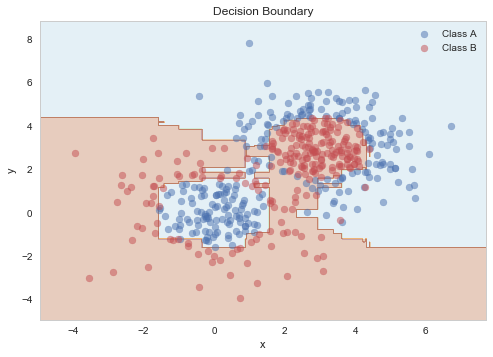

In [8]:
plot_result(model_ada)## 에이다 부스트 조금더 깔끔하게 나옴 

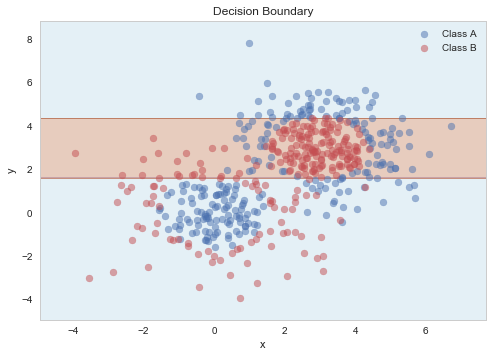

In [9]:
plot_result(model_ada.estimators_[0]) ## estimator가 0인경우 간단하게 나옴, 틀린부분만 다시 들여다봄 
## n_estimators=100: 첫번째 그림 

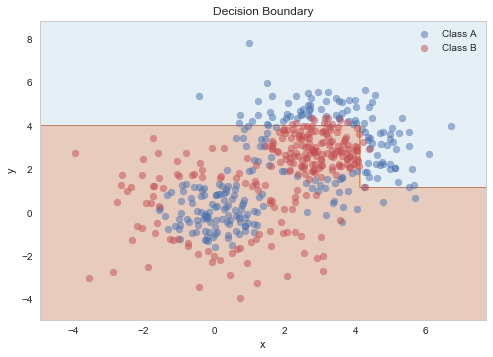

In [10]:
plot_result(model_ada.estimators_[1])

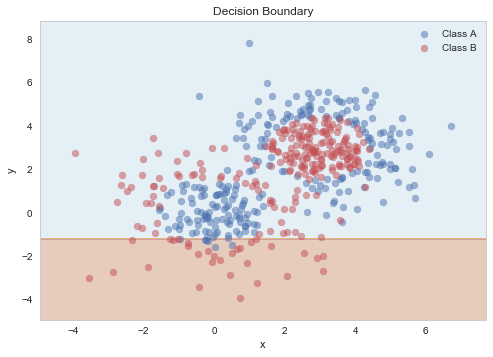

In [11]:
plot_result(model_ada.estimators_[2]) ## estimators =2 인경우 안보는 영역을 다시 골라서 해결 

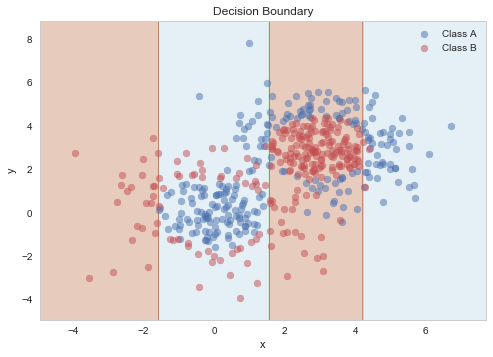

In [12]:
plot_result(model_ada.estimators_[3]) ## n_estimators=3 앞의 모형들이 하지 못한 부분을 확인하여 다시 추적 해결 (greedy)

## 그레디언트 부스트

## 그레디언트 부스트: 에이다 부스트에서 다음 Km을 찾을때 최선의 Km을 찾는 방법 

그레이던트 부스트 모형은 최적화에 사용되는 gradient descent 방법을 응용한 모형이다. 

함수 $f(x)$를 최소화하는 $x$는 다음과 같이 gradient descent 방법으로 찾을 수 있다.

$$ x_{m} = x_{m-1} - \alpha_m \dfrac{df}{dx} $$

그레디언트 부스트 모형에서는 오차 함수 또는 손실 함수(loss function) $L(y, C_{m-1})$ 을 최소화하는 weak classifier $k_m$ 은 $-\tfrac{dL(y, C_{m-1})}{dC_{m-1}}$ 임을 알 수 있다. 

$$ C_{m} = C_{m-1} - \alpha_m \dfrac{dL(y, C_{m-1})}{dC_{m-1}} = C_{m-1} + \alpha_m k_m $$

In [ ]:
## 여기서 f는 함수,x는 변수, c는 함수, L:functional  
## functional은 함수를 집어넣었을때 실수가 나오는 함수 

따라서 그레디언트 부스트 모형에서는 다음과 같은 과정을 반복한다.

1. $-\tfrac{dL(y, C_m)}{dC_m}$ 를 target으로 하는 weak classifier $k_m$ 을 찾는다. 
2. $ \left( C_m - (C_{m-1} + \alpha_m k_m) \right)^2 $ 를 최소화하는 step size $\alpha_m$ 을 찾는다. 
3. $C_m = C_{m-1} + \alpha_m k_m$ 최종 모형을 갱신한다.

weak classifier 의 구조로는 트리를 주로 사용한다.

만약 손실함수가 오차 제곱 형태라면 gradient 는 실제 target $y$ 와   $C_{m-1}$과의 차이 즉, 잔차(residual)가 된다.

$$ L(y, C_{m-1}) = \dfrac{1}{2}(y - C_{m-1})^2 $$

$$ -\dfrac{dL(y, C_m)}{dC_m} = y - C_{m-1} $$

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

model_grad = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=0)

In [15]:
%%time
model_grad.fit(X, y)

Wall time: 43.1 ms


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

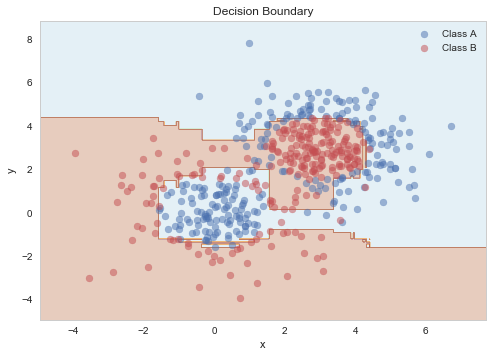

In [16]:
plot_result(model_grad)

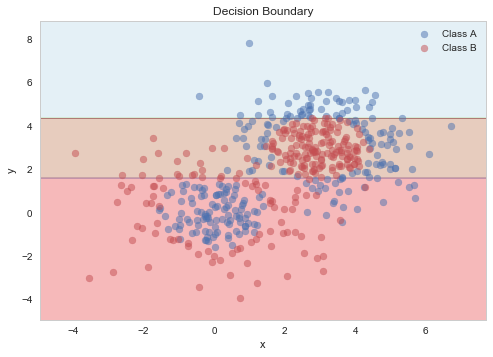

In [17]:
plot_result(model_grad.estimators_[0][0])

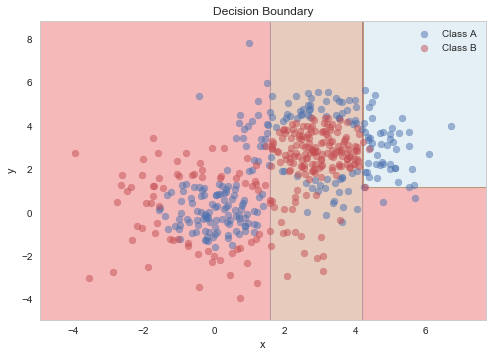

In [18]:
plot_result(model_grad.estimators_[1][0])

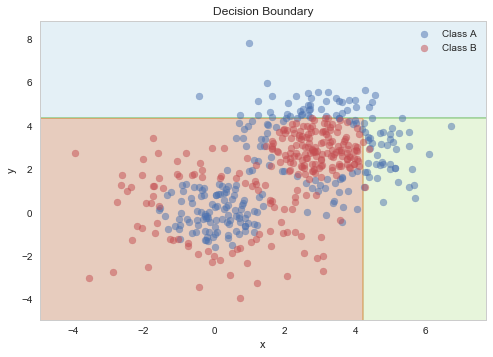

In [19]:
plot_result(model_grad.estimators_[2][0])

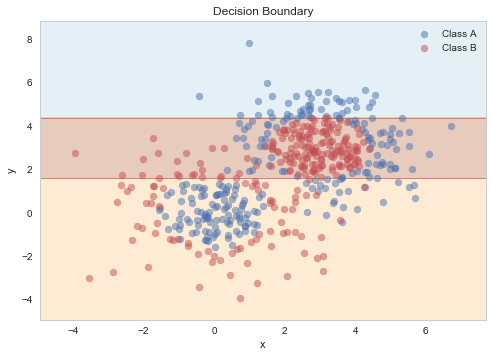

In [20]:
plot_result(model_grad.estimators_[3][0])

### XGBoost 라이브러리

In [25]:
#import os ## 패스 지정


#mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'

#os.environ['PATH'] = mingw_path + ';' + os.environ['PATH'] 


#import xgboost as xgb


In [26]:
import xgboost
## Extreme Gradient Boost 훨씬빠름 
model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=2)

In [31]:
%time
xgboost=model_xgb.fit(X, y) ## 훨씬 빠름 5 마이크로 세컨드 

Wall time: 0 ns


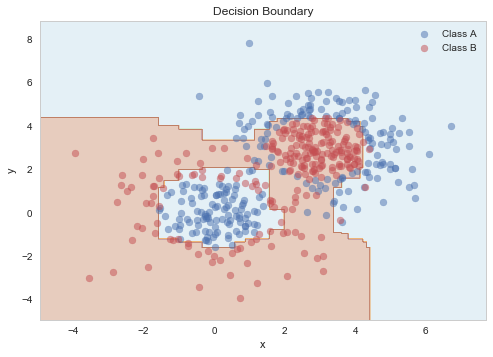

In [28]:
plot_result(model_xgb)

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0) ## 셔플로 섞어줘야함 아니면 1번부터 순서대로 샘플 뽑아줌 
for train_index, test_index in cv.split(X):
    print("test index :", test_index)
    print("." * 80 )        
    print("train index:", train_index)
    print("=" * 80 )

test index : [  1  10  12  15  21  37  45  46  54  56  60  65  75  76  78  90  96 100
 102 108 118 124 132 142 144 153 154 157 159 170 171 173 175 179 191 196
 200 205 208 213 219 220 221 224 233 235 238 240 241 250 254 264 271 276
 283 289 295 300 301 311 316 322 325 326 327 329 330 340 342 343 348 353
 355 362 363 366 367 372 374 379 387 390 402 403 418 421 425 428 438 440
 445 451 461 468 469 475 484 489 491 492]
................................................................................
train index: [  0   2   3   4   5   6   7   8   9  11  13  14  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39  40  41
  42  43  44  47  48  49  50  51  52  53  55  57  58  59  61  62  63  64
  66  67  68  69  70  71  72  73  74  77  79  80  81  82  83  84  85  86
  87  88  89  91  92  93  94  95  97  98  99 101 103 104 105 106 107 109
 110 111 112 113 114 115 116 117 119 120 121 122 123 125 126 127 128 129
 130 131 133 134 135 136 137 138 139 140 141 143

In [34]:
from sklearn.model_selection import cross_val_score

cross_val_score(xgboost, X, y, scoring="accuracy", cv=5) ## 셋1,2,3,4,5 에 대한 성능값 


array([ 0.8 ,  0.68,  0.9 ,  0.81,  0.88])